In [2]:
import torch

print("Torch version:",torch.__version__)
print(torch.backends.mps.is_available())

Torch version: 2.2.0.dev20231001
True
Is CUDA enabled? False


Mounting the google drive and making sure we have the right stuff!

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Image Domain"
%ls

Mounted at /content/drive
/content/drive/My Drive/Image Domain
BasicEncoderRun.ipynb  InDomain/           OutDomain/        VAEncoderRun.ipynb
Cavity_images/         mean_train_kde.png  TrainingImages/   vae.yaml
CNNEncoderRun.ipynb    model.pth           VAEInstall.ipynb


Importing the libraries!

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image, ImageFilter
import glob

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, datasets

Checking if we have GPU access!

In [ ]:
import torch
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Please set GPU via Edit -> Notebook Settings.


Preprocessing the images to have a size of 1024, 1024 for now because I don't know what else to do. Also loading the training images as a tensor. Made a function to load the images in.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import torchvision.transforms.functional as T
TRAIN_UNDERFOCUS_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/cavity_nome_underfocus_only/train'
TRAIN_OVERFOCUS_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/cavity_nome_overfocus_only/train'
VAL_UNDERFOCUS_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/cavity_nome_underfocus_only/val'
VAL_OVERFOCUS_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/cavity_nome_overfocus_only/val'
CNL_UNDEROVERFOCUS_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/cavity_CNL_cleaned/train'
LOOPS_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/loops_images'
RANDOM_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/random_images'
CHEN_IMAGE_PATH = '/content/drive/My Drive/Image Domain/Cavity_images/cavity_chen'


def load_images(image_path, desired_height, desired_width, file_extension, contrast=False, contrastfactor = 0.5, blur = False, blur_factor = 10):
  image_list = []
  for filename in glob.glob(image_path + "/*" + file_extension):
      im=Image.open(filename)
      transform = transforms.Compose([ #Rotations, and rescaling, flipping, cropping
        transforms.Resize((desired_height, desired_width)),
        transforms.ToTensor()
      ])
      if(contrast == True):
        im = T.adjust_contrast(im, contrast_factor=contrastfactor)
      elif(blur == True):
        im = im.filter(ImageFilter.GaussianBlur(blur_factor))
      transformed_im = transform(im)
      image_list.append(transformed_im)
  for filename in glob.glob(image_path + "/*" + ".webp"):
    im=Image.open(filename)
    transform = transforms.Compose([ #Rotations, and rescaling, flipping, cropping
      transforms.Resize((desired_height, desired_width)),
      transforms.ToTensor()
    ])
    if(contrast == True):
      im = T.adjust_contrast(im, contrast_factor=contrastfactor)
    elif(blur == True):
      im = im.filter(ImageFilter.GaussianBlur(blur_factor))
    transformed_im = transform(im)
    image_list.append(transformed_im)
  num_images = len(image_list)
  num_channels, height, width = image_list[0].shape
  image_tensor = torch.zeros((num_images, 1, height, width), device='cuda')
  for i, image in enumerate(image_list):
    if(image.size()[0] == 3):
      image_tensor[i, 0, :, :] = torch.mean(image, dim=0)
    else:
      image_tensor[i, :, :, :] = image
  reshaped_tensor = image_tensor.view(num_images * height * width, 1)
  image_tensor = reshaped_tensor.view(num_images, 1, height, width)
  return image_tensor

Making the train images

In [ ]:
from sklearn.model_selection import train_test_split
train_image_underfocus_tensor = load_images(TRAIN_UNDERFOCUS_IMAGE_PATH, 1024, 1024, ".png")
train_image_overfocus_tensor = load_images(TRAIN_OVERFOCUS_IMAGE_PATH, 1024, 1024, ".png")
indomain_underfocus_image_tensor = load_images(VAL_UNDERFOCUS_IMAGE_PATH, 1024, 1024, ".png")
indomain_overfocus_image_tensor = load_images(VAL_OVERFOCUS_IMAGE_PATH, 1024, 1024, ".png")
indomain_image_tensor = torch.cat((indomain_underfocus_image_tensor, indomain_overfocus_image_tensor), 0)

train_tensor = torch.cat((train_image_underfocus_tensor, train_image_overfocus_tensor, indomain_image_tensor), 0)
Train_tensor, Test_tensor = train_test_split(train_tensor, test_size = 0.2)
image_load = torch.utils.data.DataLoader(Train_tensor, batch_size=16, shuffle=False)

Testing out different architectures to see how the layers behave with the changes.

In [ ]:
#batch_size, in_channels, height, width = image_tensor.size()
#conv_layer = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

Making the architecture for the autoencoder

In [ ]:
class Autoencoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    # Add more layers, Conv 2D Layers
    self.encoder = torch.nn.Sequential( #Dimensions 1024*1024*1
        torch.nn.Conv2d(1, 2, kernel_size=6, stride=4, padding=1, padding_mode='zeros'), #Dimensions 256*256*3
        torch.nn.LeakyReLU(),
        torch.nn.Conv2d(2, 4, kernel_size=6, stride=4, padding=1, padding_mode='zeros'), #Dimensions 64*64*6
        torch.nn.LeakyReLU(),
        #torch.nn.Conv2d(4, 16, kernel_size=6, stride=4, padding=1, padding_mode='zeros'), #Dimensions 16*16*16
        #torch.nn.LeakyReLU(),
        #torch.nn.Conv2d(16, 32, kernel_size=6, stride=4, padding=1, padding_mode='zeros'), #Dimensions 4*4*32
        #torch.nn.LeakyReLU(),
        #torch.nn.Conv2d(32, 64, kernel_size=6, stride=4, padding=1, padding_mode='zeros'), #Dimensions 1*1*64
        ## Potential reducing the number of channels?? doing a 1x1 convolution layer to reduce the numbers to deal with
        #torch.nn.MaxPool2d((8, 8), stride=(4, 4), padding = (2, 2), return_indices=True),  #Dimensions 16*16*6
    )
    self.decoder = torch.nn.Sequential( #Dimensions: 16*16*6
        #torch.nn.ConvTranspose2d(64, 32, kernel_size=6, stride=4, padding=2, output_padding=2),
        #orch.nn.LeakyReLU(),
        #torch.nn.ConvTranspose2d(32, 16, kernel_size=6, stride=4, padding=2, output_padding=2), #Dimensions 4*4*32
        #torch.nn.LeakyReLU(),
        #torch.nn.ConvTranspose2d(16, 4, kernel_size=6, stride=4, padding=2, output_padding=2), #64*64*6
        #torch.nn.LeakyReLU(),
        torch.nn.ConvTranspose2d(4, 2, kernel_size=6, stride=4, padding=2, output_padding=2),
        torch.nn.LeakyReLU(),
        torch.nn.ConvTranspose2d(2, 1, kernel_size=6, stride=4, padding=2, output_padding=2)
    )

  def forward(self, x):
    encoded= self.encoder(x)
    #unpool_encoded = torch.nn.functional.max_unpool2d(encoded, indices, kernel_size = 8, stride=4, padding=2)
    decoded = self.decoder(encoded)
    return decoded, encoded

In [ ]:
#  use gpu if available
device = torch.device("cuda")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder().to(device)
print("Loading the created model")
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = torch.nn.MSELoss()


Loading the created model


In [ ]:
epochs = 120
outputs = []
loss = 0
i = 0
all_outputs = torch.zeros(0)
all_vectors = torch.zeros(0)

best_loss = float('inf')  # Initialize the best loss variable
patience = 5  # Number of epochs with increasing loss allowed
count = 0  # Count the number of epochs with increasing loss


for epoch in range(epochs):
  for batch_features in image_load:
    batch_features = batch_features.to(device)
    optimizer.zero_grad()
    #Images created
    outputs, latent_vector = model(batch_features)
    if(epoch == epochs - 1):
      all_outputs = torch.cat((all_outputs, outputs.cpu()))
      latent_vector = latent_vector.view(batch_features.size()[0], -1)
      print(latent_vector.size())
      all_vectors = torch.cat((all_vectors, latent_vector.cpu()))
    # compute training reconstruction loss
    train_loss = criterion(outputs, batch_features)
    # compute accumulated gradients
    train_loss.backward()
    # perform parameter update based on current gradients
    optimizer.step()
    # add the mini-batch training loss to epoch loss
    loss += train_loss.item()

  loss = loss / len(image_load)
  print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

torch.save(model.state_dict(), '/content/drive/My Drive/Image Domain/model.pth')

epoch : 1/120, loss = 0.388590
epoch : 2/120, loss = 0.420165
epoch : 3/120, loss = 0.395186
epoch : 4/120, loss = 0.340780
epoch : 5/120, loss = 0.263028
epoch : 6/120, loss = 0.197843
epoch : 7/120, loss = 0.146853
epoch : 8/120, loss = 0.103030
epoch : 9/120, loss = 0.072488
epoch : 10/120, loss = 0.052109
epoch : 11/120, loss = 0.038426
epoch : 12/120, loss = 0.029208
epoch : 13/120, loss = 0.022840
epoch : 14/120, loss = 0.018311
epoch : 15/120, loss = 0.015041
epoch : 16/120, loss = 0.012688
epoch : 17/120, loss = 0.010989
epoch : 18/120, loss = 0.009737
epoch : 19/120, loss = 0.008787
epoch : 20/120, loss = 0.008047
epoch : 21/120, loss = 0.007459
epoch : 22/120, loss = 0.006986
epoch : 23/120, loss = 0.006603
epoch : 24/120, loss = 0.006293
epoch : 25/120, loss = 0.006044
epoch : 26/120, loss = 0.005844
epoch : 27/120, loss = 0.005683
epoch : 28/120, loss = 0.005554
epoch : 29/120, loss = 0.005448
epoch : 30/120, loss = 0.005362
epoch : 31/120, loss = 0.005289
epoch : 32/120, l

Create a prediction part to this so that we can use that to train on this model! Loading the model in this part!

In [ ]:
device = torch.device("cuda")
model_path = '/content/drive/My Drive/Image Domain/model.pth'
predict_model = Autoencoder().to(device)
predict_model.load_state_dict(torch.load(model_path))
predict_model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 2, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(2, 4, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 2, kernel_size=(6, 6), stride=(4, 4), padding=(2, 2), output_padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(2, 1, kernel_size=(6, 6), stride=(4, 4), padding=(2, 2), output_padding=(2, 2))
  )
)

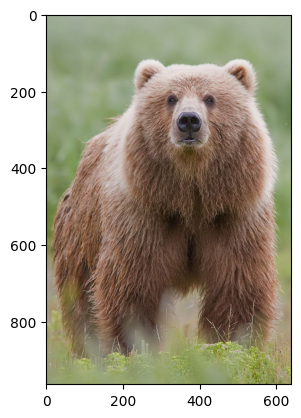

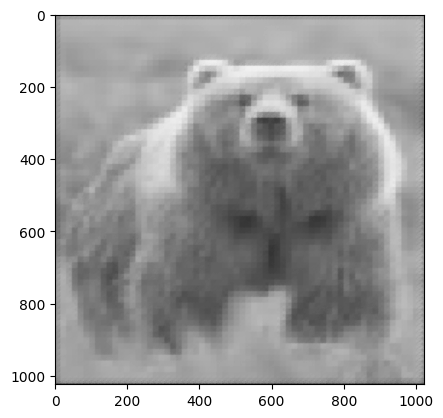

In [ ]:
Bear_image = "/content/drive/My Drive/Image Domain/Cavity_images/random_images/640px-2010-brown-bear.jpeg"
im=Image.open(Bear_image)
plt.gray()
plt.imshow(im)
plt.show()

transform = transforms.Compose([ #Rotations, and rescaling, flipping, cropping
  transforms.Resize((1024, 1024)),
  transforms.ToTensor()
])
transformed_im = transform(im)

# Additional code snippet
if transformed_im.size()[0] == 3:
    transformed_im = torch.mean(transformed_im, dim=0, keepdim=True)
else:
    transformed_im = transformed_im


# Perform prediction using the autoencoder
with torch.no_grad():
    decoded_image, latent_vector = predict_model(transformed_im.to('cuda'))


# Convert the tensor to a NumPy array and adjust the data type
image_array = decoded_image.cpu().numpy()
# Reshape the array if needed
item = image_array.reshape((-1, 1024, 1024))
plt.imshow(item[0])

plt.show()

# decoded_image.save('decoded_image.jpg')


Make it a big vector and spit it out! and then use that to find the kde

torch.Size([122, 16384])


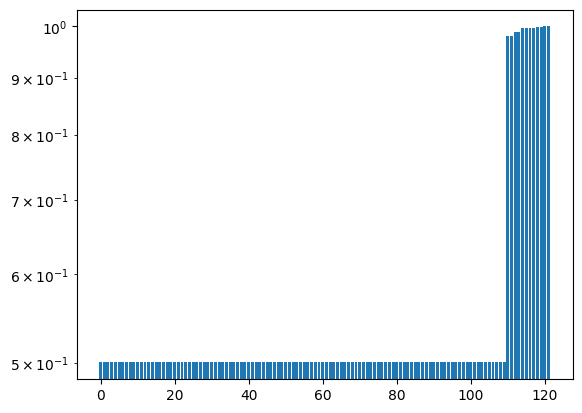

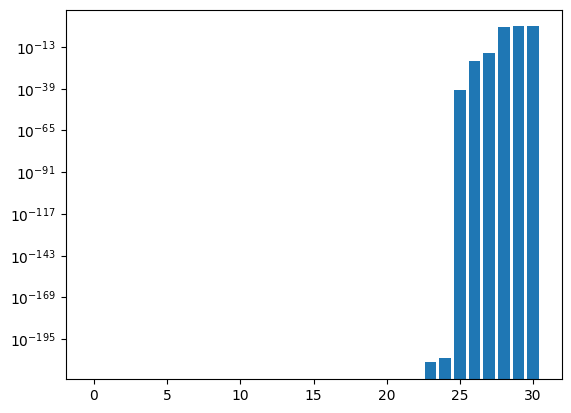

In Domain:  [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 2.39569426e-210
 1.13875850e-207 1.69484588e-040 7.31371358e-023 1.11122891e-017
 4.58660643e-001 4.65654049e-001 4.74418836e-001]


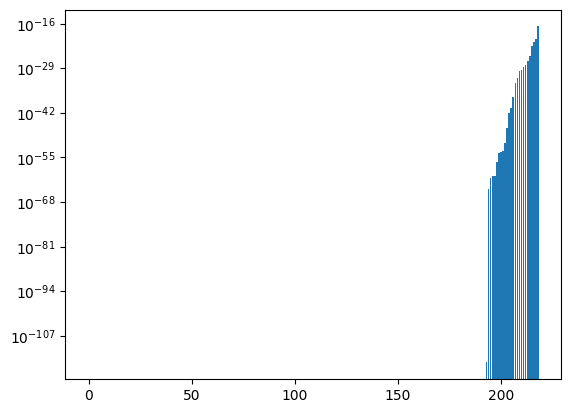

CNL_UNDEROVERFOCUS [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.000

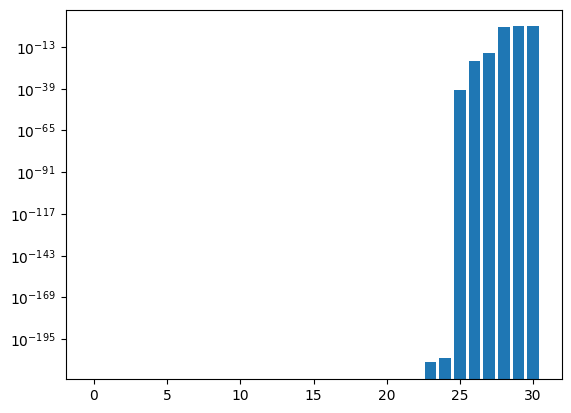

In Domain:  [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 2.39569426e-210
 1.13875850e-207 1.69484588e-040 7.31371358e-023 1.11122891e-017
 4.58660643e-001 4.65654049e-001 4.74418836e-001]


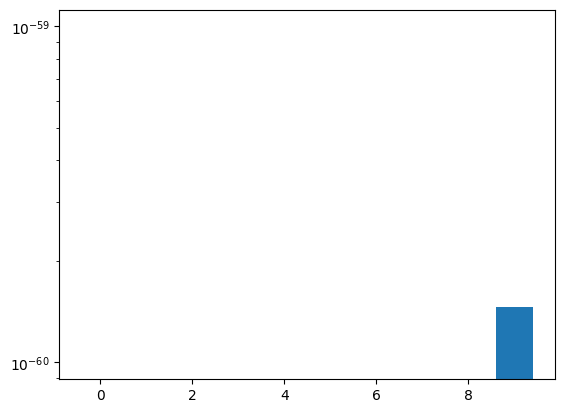

LOOP_IMAGES [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.45825457e-60]


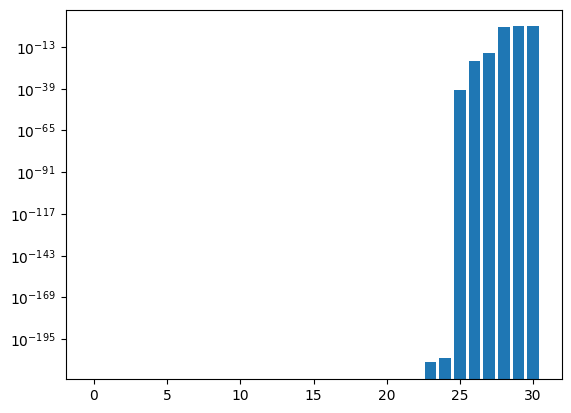

In Domain:  [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 2.39569426e-210
 1.13875850e-207 1.69484588e-040 7.31371358e-023 1.11122891e-017
 4.58660643e-001 4.65654049e-001 4.74418836e-001]


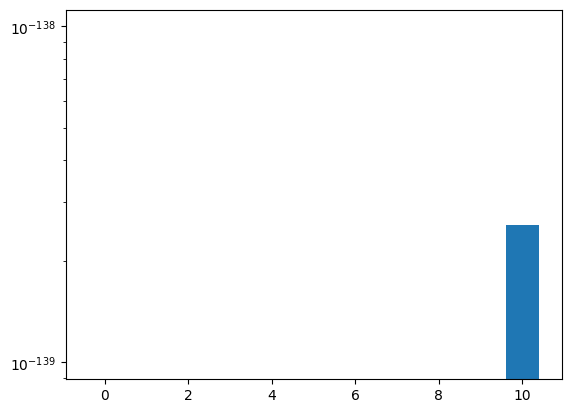

RANDOM_IMAGES [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 2.56083925e-139]


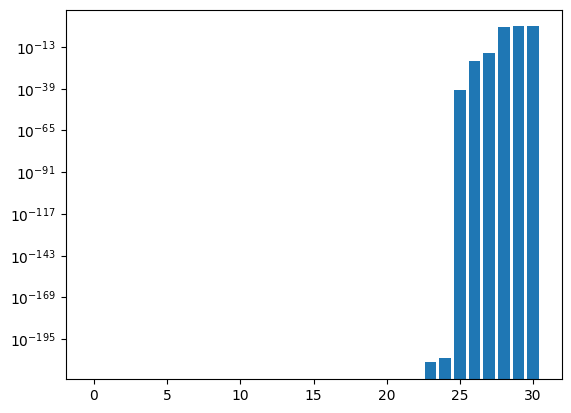

In Domain:  [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 2.39569426e-210
 1.13875850e-207 1.69484588e-040 7.31371358e-023 1.11122891e-017
 4.58660643e-001 4.65654049e-001 4.74418836e-001]


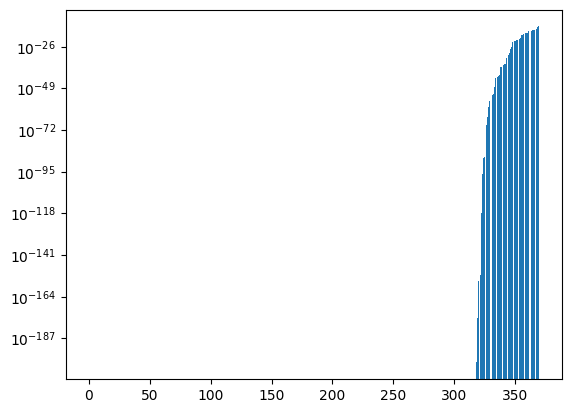

CHEN_IMAGE [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+0

In [ ]:
from scipy.stats import gaussian_kde
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity

from sklearn.cluster import estimate_bandwidth
#bandwidth = estimate_bandwidth(all_vectors.detach().numpy(), quantile = 0.5)

Name_dict = {CNL_UNDEROVERFOCUS_IMAGE_PATH: "CNL_UNDEROVERFOCUS", LOOPS_IMAGE_PATH: "LOOP_IMAGES", RANDOM_IMAGE_PATH: "RANDOM_IMAGES", CHEN_IMAGE_PATH: "CHEN_IMAGE"}
extension_dict = {CNL_UNDEROVERFOCUS_IMAGE_PATH: "jpg", LOOPS_IMAGE_PATH: ".jpg", RANDOM_IMAGE_PATH: "jpeg", CHEN_IMAGE_PATH: ".png"}

print(all_vectors.size())
kde = KernelDensity(kernel='gaussian', bandwidth="scott").fit(all_vectors.detach().numpy())
#Sklearn kde,
log_density = kde.score_samples(all_vectors.detach().numpy())
#print(log_density)

max_log_density = np.max(log_density)
min_log_density = np.min(log_density)


max_in = np.max(log_density)
trans = lambda x: np.exp(x-max_in)

log_train = trans(log_density)
log_train.sort()
plt.yscale("log")
plt.bar(torch.arange(0, all_vectors.size()[0]), log_train)
plt.show()

#print(log_density)
#print(np.exp(log_density-max_in))
#print(max_in)
#print(kde)


for image_path in [CNL_UNDEROVERFOCUS_IMAGE_PATH, LOOPS_IMAGE_PATH, RANDOM_IMAGE_PATH, CHEN_IMAGE_PATH]:
  indomain_image_load = torch.utils.data.DataLoader(Test_tensor, batch_size=16, shuffle=False)
  all_indomain_latentspaces = torch.zeros(0)
  with torch.no_grad():
    for batch_features in indomain_image_load:
      predict_outputs, indomain_latentspaces = predict_model(batch_features)
      indomain_latentspaces = indomain_latentspaces.view(indomain_latentspaces.size()[0], -1)
      all_indomain_latentspaces = torch.cat((all_indomain_latentspaces, indomain_latentspaces.cpu()))
  log_in_density = kde.score_samples(all_indomain_latentspaces.detach().numpy())

  in_train = trans(log_in_density)
  in_train.sort()
  plt.yscale("log")
  plt.bar(torch.arange(0, all_indomain_latentspaces.size()[0]), in_train)
  plt.show()
  print("In Domain: ", in_train)

  #Out of Domain - OOD
  outdomain_total = load_images(image_path, 1024, 1024, extension_dict[image_path])
  outdomain_load = torch.utils.data.DataLoader(outdomain_total, batch_size=16, shuffle=False)
  all_outdomain_latentspaces = torch.zeros(0)
  with torch.no_grad():
    for batch_features in outdomain_load:
      predict_outputs, outdomain_latentspaces = predict_model(batch_features)
      outdomain_latentspaces = outdomain_latentspaces.view(outdomain_latentspaces.size()[0], -1)
      all_outdomain_latentspaces = torch.cat((all_outdomain_latentspaces, outdomain_latentspaces.cpu()))

  log_out_density = kde.score_samples(all_outdomain_latentspaces.detach().numpy())
  out_train = trans(log_out_density)
  out_train.sort()
  plt.yscale("log")
  plt.bar(torch.arange(0, all_outdomain_latentspaces.size()[0]), out_train)
  plt.show()
  print(Name_dict[image_path], out_train)


Using the out of domain images to actually do the predictions and seeing what the outcome is!

In [ ]:
#In Domain - ID
contrasts = [0, 0.001, 0.01, 0.1, 0.5, 0.8, 1, 2, 4, 16]
blurs = [0, 1, 10, 20, 50, 100, 200, 400, 800]
contrast_dict = {}
for contrast in contrasts:
  indomain_underfocus_image_tensor = load_images(VAL_UNDERFOCUS_IMAGE_PATH, 1024, 1024, ".png", contrast = True, contrastfactor= contrast)
  indomain_overfocus_image_tensor = load_images(VAL_OVERFOCUS_IMAGE_PATH, 1024, 1024, ".png", contrast = True, contrastfactor = contrast)
  indomain_image_tensor = torch.cat((indomain_underfocus_image_tensor, indomain_overfocus_image_tensor), 0)
  indomain_image_load = torch.utils.data.DataLoader(indomain_image_tensor, batch_size=16, shuffle=False)
  all_indomain_latentspaces = torch.zeros(0)
  with torch.no_grad():
    for batch_features in indomain_image_load:
      predict_outputs, indomain_latentspaces = predict_model(batch_features)
      indomain_latentspaces = indomain_latentspaces.view(indomain_latentspaces.size()[0], -1)
      all_indomain_latentspaces = torch.cat((all_indomain_latentspaces, indomain_latentspaces.cpu()))
  contrast_dict[contrast] = all_indomain_latentspaces
  print(all_indomain_latentspaces.size())

blur_dict = {}
for blur in blurs:
  indomain_underfocus_image_tensor = load_images(VAL_UNDERFOCUS_IMAGE_PATH, 1024, 1024, ".png", blur = True, blur_factor = blur)
  indomain_overfocus_image_tensor = load_images(VAL_OVERFOCUS_IMAGE_PATH, 1024, 1024, ".png", blur = True, blur_factor = blur)
  indomain_image_tensor = torch.cat((indomain_underfocus_image_tensor, indomain_overfocus_image_tensor), 0)
  indomain_image_load = torch.utils.data.DataLoader(indomain_image_tensor, batch_size=16, shuffle=False)
  all_indomain_latentspaces = torch.zeros(0)
  with torch.no_grad():
    for batch_features in indomain_image_load:
      predict_outputs, indomain_latentspaces = predict_model(batch_features)
      indomain_latentspaces = indomain_latentspaces.view(indomain_latentspaces.size()[0], -1)
      all_indomain_latentspaces = torch.cat((all_indomain_latentspaces, indomain_latentspaces.cpu()))
  blur_dict[blur] = all_indomain_latentspaces
  print(all_indomain_latentspaces.size())

Getting the histograms we created from the encoded parts to see how do they look

(4096,)


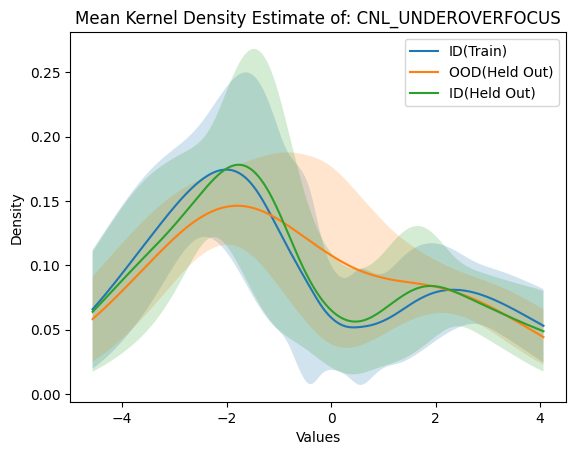

In Domain Area for Kernel Density Estimate:  CNL_UNDEROVERFOCUS 0.06520511149678307
<class 'numpy.ndarray'>
Out of Domain Area for Kernel Density Estimate:  CNL_UNDEROVERFOCUS 0.17363331980626256
31
4096


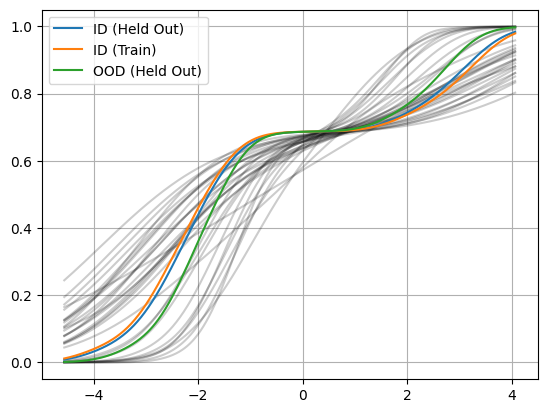

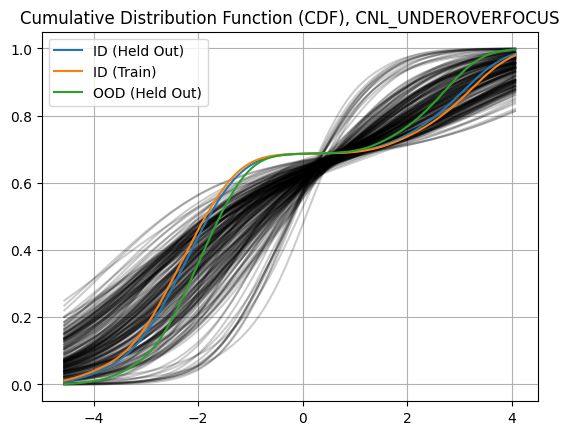

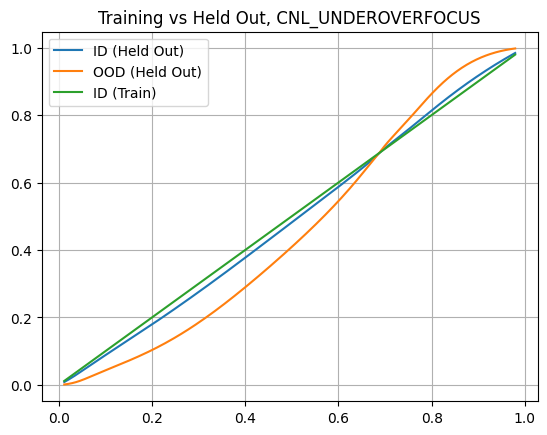

Max out from the in-domain:  [0.44260911470746467, 1.1851629083485902, 1.2381170688439405, 0.5959337600342625, 0.6313217596926617, 0.8308252292076259, 0.648447326927254, 0.9764327043695515, 0.44124320424334557, 0.45400261535627406, 0.7128543277726089, 0.5263124336953071, 1.3821856432463984, 1.0254979780475981, 0.8357754343578639, 0.4656535821291615, 0.7640301400218428, 0.34988555529685483, 0.5374396699189736, 0.557920599616458, 0.6296905677607925, 0.4732394122682698, 0.3923548335257958, 0.4273875606597455, 1.258444457575361, 0.417616253309123, 0.4548380153143587, 0.7454990133140892, 1.0590914792030959, 0.3625278651875628, 0.7264477168773364]
0.6951222009945023
Max out from out-domain:  [1.5008032864566885, 1.1467468829077843, 0.9189497639556868, 1.017615632166555, 0.5391062344793445, 0.8958278884190726, 0.6777035097183093, 0.4794893696149001, 1.110027366616532, 0.6046541510770038, 1.6559887711419112, 1.5911387451930816, 0.6770875419233978, 1.637954365028943, 1.199313848326562, 1.115136

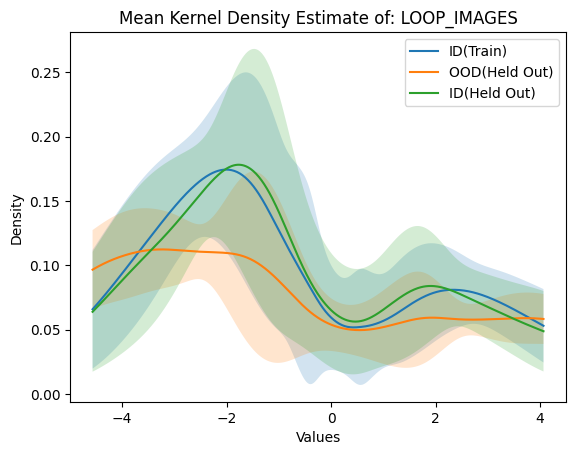

In Domain Area for Kernel Density Estimate:  LOOP_IMAGES 0.06520511149678307
<class 'numpy.ndarray'>
Out of Domain Area for Kernel Density Estimate:  LOOP_IMAGES 0.2014672372270644
31
4096


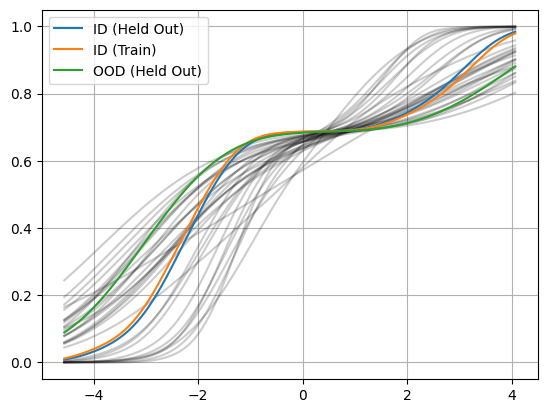

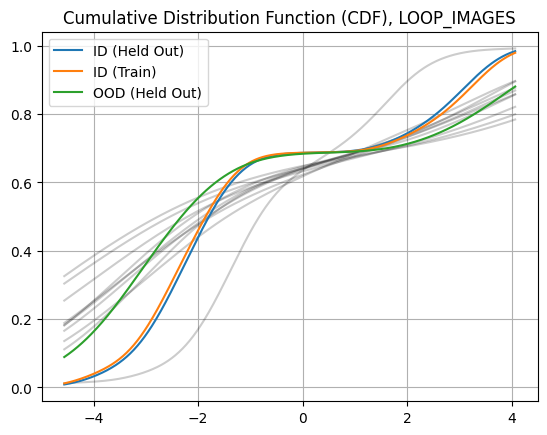

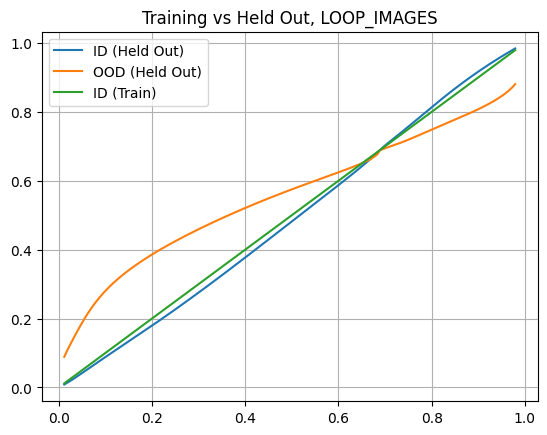

Max out from the in-domain:  [0.44260911470746467, 1.1851629083485902, 1.2381170688439405, 0.5959337600342625, 0.6313217596926617, 0.8308252292076259, 0.648447326927254, 0.9764327043695515, 0.44124320424334557, 0.45400261535627406, 0.7128543277726089, 0.5263124336953071, 1.3821856432463984, 1.0254979780475981, 0.8357754343578639, 0.4656535821291615, 0.7640301400218428, 0.34988555529685483, 0.5374396699189736, 0.557920599616458, 0.6296905677607925, 0.4732394122682698, 0.3923548335257958, 0.4273875606597455, 1.258444457575361, 0.417616253309123, 0.4548380153143587, 0.7454990133140892, 1.0590914792030959, 0.3625278651875628, 0.7264477168773364]
0.6951222009945023
Max out from out-domain:  [0.7558929306156617, 0.7453453498427944, 0.940273600478233, 1.101173457877471, 0.694773687144572, 0.6558987798824908, 0.6135656399921126, 1.0480762612459187, 0.5446730145888401, 1.0392585751928365]
0.813893129686093
Area between the training CDF, and the out of domain CDF:  0.5728992039021765
Area betwee

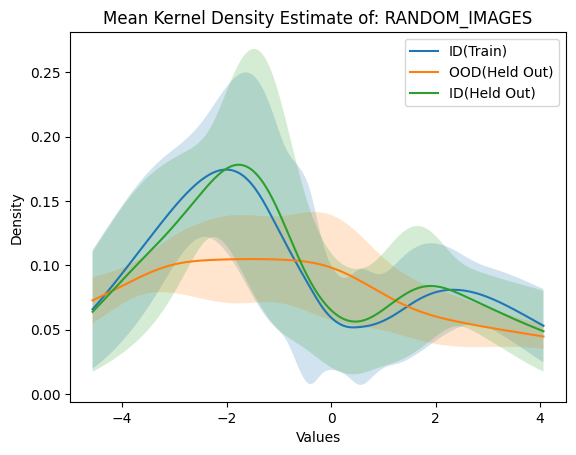

In Domain Area for Kernel Density Estimate:  RANDOM_IMAGES 0.06520511149678307
<class 'numpy.ndarray'>
Out of Domain Area for Kernel Density Estimate:  RANDOM_IMAGES 0.24790989530898475
31
4096


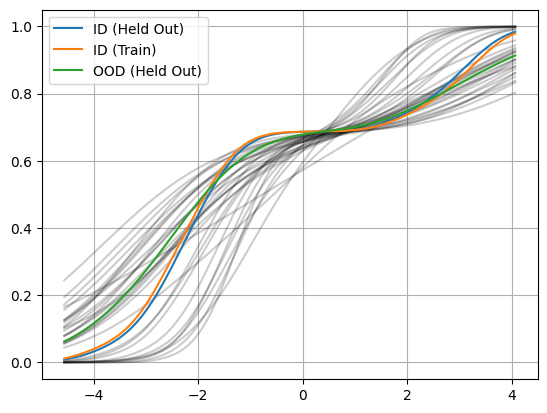

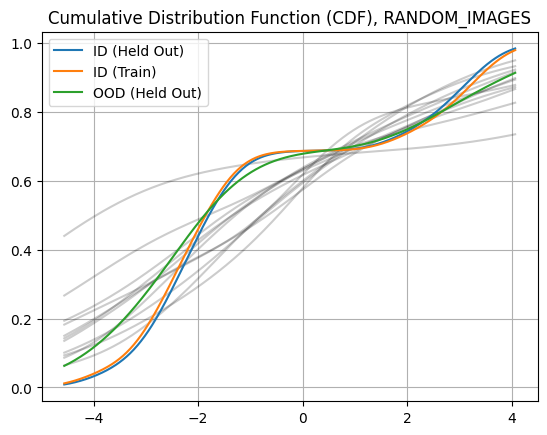

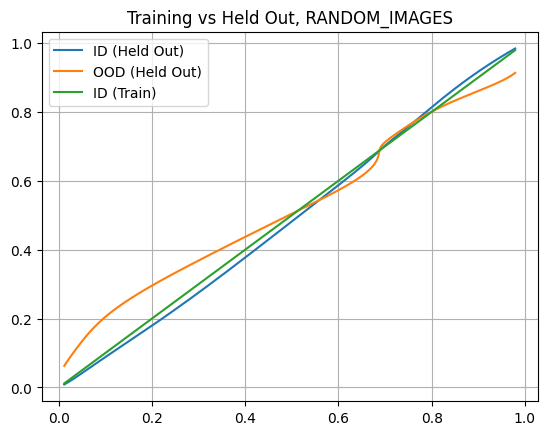

Max out from the in-domain:  [0.44260911470746467, 1.1851629083485902, 1.2381170688439405, 0.5959337600342625, 0.6313217596926617, 0.8308252292076259, 0.648447326927254, 0.9764327043695515, 0.44124320424334557, 0.45400261535627406, 0.7128543277726089, 0.5263124336953071, 1.3821856432463984, 1.0254979780475981, 0.8357754343578639, 0.4656535821291615, 0.7640301400218428, 0.34988555529685483, 0.5374396699189736, 0.557920599616458, 0.6296905677607925, 0.4732394122682698, 0.3923548335257958, 0.4273875606597455, 1.258444457575361, 0.417616253309123, 0.4548380153143587, 0.7454990133140892, 1.0590914792030959, 0.3625278651875628, 0.7264477168773364]
0.6951222009945023
Max out from out-domain:  [0.8941624069318692, 0.6464433673605887, 0.6721362260583348, 0.5133627755607781, 0.7994739300190352, 0.6687517023090657, 0.8168904753103411, 0.6136377855060319, 0.5984427358843611, 0.7955728906511156, 1.393988091540003]
0.7648056715574113
Area between the training CDF, and the out of domain CDF:  0.31344

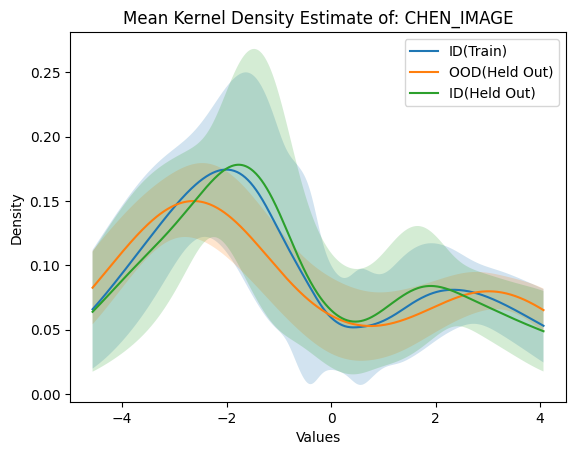

In Domain Area for Kernel Density Estimate:  CHEN_IMAGE 0.06520511149678307
<class 'numpy.ndarray'>
Out of Domain Area for Kernel Density Estimate:  CHEN_IMAGE 0.11670000755638328
31
4096


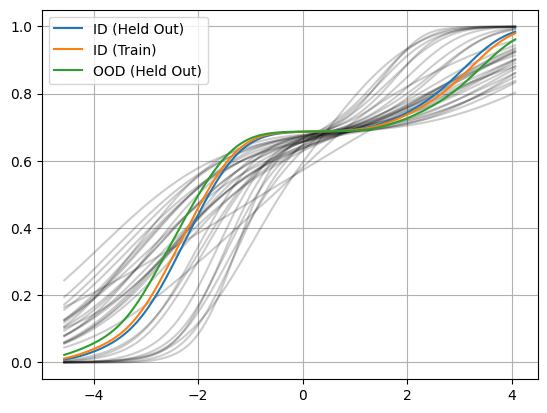

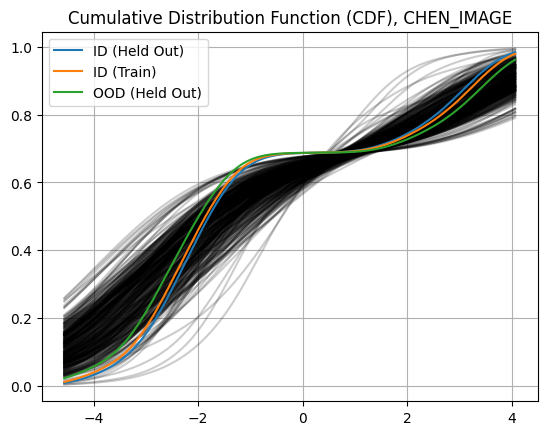

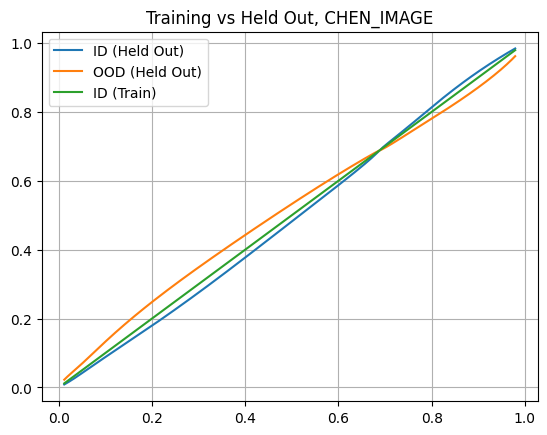

Max out from the in-domain:  [0.44260911470746467, 1.1851629083485902, 1.2381170688439405, 0.5959337600342625, 0.6313217596926617, 0.8308252292076259, 0.648447326927254, 0.9764327043695515, 0.44124320424334557, 0.45400261535627406, 0.7128543277726089, 0.5263124336953071, 1.3821856432463984, 1.0254979780475981, 0.8357754343578639, 0.4656535821291615, 0.7640301400218428, 0.34988555529685483, 0.5374396699189736, 0.557920599616458, 0.6296905677607925, 0.4732394122682698, 0.3923548335257958, 0.4273875606597455, 1.258444457575361, 0.417616253309123, 0.4548380153143587, 0.7454990133140892, 1.0590914792030959, 0.3625278651875628, 0.7264477168773364]
0.6951222009945023
Max out from out-domain:  [0.4640574052841921, 0.4330932015847895, 0.6110546156834706, 0.5883937244527677, 0.6066380400077084, 0.5826131101654224, 0.5910926060074654, 0.4216220280372386, 0.5100248849960646, 0.5725397554675467, 0.5808839202205269, 0.6501642878771068, 0.6596490174937403, 0.6338696115641644, 0.5969861578814055, 0.61

In [ ]:
from scipy.stats import gaussian_kde
Name_dict = {CNL_UNDEROVERFOCUS_IMAGE_PATH: "CNL_UNDEROVERFOCUS", LOOPS_IMAGE_PATH: "LOOP_IMAGES", RANDOM_IMAGE_PATH: "RANDOM_IMAGES", CHEN_IMAGE_PATH: "CHEN_IMAGE"}
extension_dict = {CNL_UNDEROVERFOCUS_IMAGE_PATH: "jpg", LOOPS_IMAGE_PATH: ".jpg", RANDOM_IMAGE_PATH: "jpeg", CHEN_IMAGE_PATH: ".png"}
for image_path in [CNL_UNDEROVERFOCUS_IMAGE_PATH, LOOPS_IMAGE_PATH, RANDOM_IMAGE_PATH, CHEN_IMAGE_PATH]:

  #Out of Domain - OOD
  outdomain_total = load_images(image_path, 1024, 1024, extension_dict[image_path])
  outdomain_load = torch.utils.data.DataLoader(outdomain_total, batch_size=16, shuffle=False)
  all_outdomain_latentspaces = torch.zeros(0)
  with torch.no_grad():
    for batch_features in outdomain_load:
      predict_outputs, outdomain_latentspaces = predict_model(batch_features)
      outdomain_latentspaces = outdomain_latentspaces.view(outdomain_latentspaces.size()[0], -1)
      all_outdomain_latentspaces = torch.cat((all_outdomain_latentspaces, outdomain_latentspaces.cpu()))

  #In Domain - ID
  indomain_image_load = torch.utils.data.DataLoader(Test_tensor, batch_size=16, shuffle=False)
  all_indomain_latentspaces = torch.zeros(0)
  with torch.no_grad():
    for batch_features in indomain_image_load:
      predict_outputs, indomain_latentspaces = predict_model(batch_features)
      indomain_latentspaces = indomain_latentspaces.view(indomain_latentspaces.size()[0], -1)
      all_indomain_latentspaces = torch.cat((all_indomain_latentspaces, indomain_latentspaces.cpu()))

  train_kde_estimates = []
  out_kde_estimates = []
  in_kde_estimates = []
  # Calculate mean for train vectors, out of domain, and in-domain latentspaces
  train_mean = np.mean([row.detach().numpy() for row in all_vectors], axis=0)
  out_mean = np.mean([row.detach().numpy() for row in all_outdomain_latentspaces], axis=0)
  in_vectors = []
  in_mean = np.mean([row.detach().numpy() for row in all_indomain_latentspaces], axis=0)
  print(in_mean.shape)
  for row in all_indomain_latentspaces:
    in_vectors.append(row.detach().numpy())

  # Kernel density estimate for train vectors
  train_kde_estimates = [gaussian_kde(row.detach().numpy()) for row in all_vectors]
  x = np.linspace(min(train_mean), max(train_mean), 500)
  train_mean_kde = np.mean([kde(x) for kde in train_kde_estimates], axis=0)
  train_std_kde = np.std([kde(x) for kde in train_kde_estimates], axis=0)
  train_lower_bound = train_mean_kde - train_std_kde
  train_upper_bound = train_mean_kde + train_std_kde

  # Kernel density estimate for out-of-domain latentspaces
  out_kde_estimates = [gaussian_kde(row.detach().numpy()) for row in all_outdomain_latentspaces]
  out_mean_kde = np.mean([kde(x) for kde in out_kde_estimates], axis=0)
  out_vectors = []
  out_std_kde = np.std([kde(x) for kde in out_kde_estimates], axis=0)
  out_lower_bound = out_mean_kde - out_std_kde
  out_upper_bound = out_mean_kde + out_std_kde
  for row in all_outdomain_latentspaces:
    out_vectors.append(row.detach().numpy())

  in_kde_estimates = [gaussian_kde(row.detach().numpy()) for row in all_indomain_latentspaces]
  in_mean_kde = np.mean([kde(x) for kde in in_kde_estimates], axis=0)
  in_std_kde = np.std([kde(x) for kde in in_kde_estimates], axis=0)
  in_lower_bound = in_mean_kde - in_std_kde
  in_upper_bound = in_mean_kde + in_std_kde

  # Plot the mean kernel density estimate
  plt.plot(x, train_mean_kde, label="ID(Train)")
  plt.plot(x, out_mean_kde, label="OOD(Held Out)")
  plt.plot(x, in_mean_kde, label = "ID(Held Out)")
  plt.fill_between(x, train_lower_bound, train_upper_bound, alpha = 0.2)
  plt.fill_between(x, out_lower_bound, out_upper_bound, alpha = 0.2)
  plt.fill_between(x, in_lower_bound, in_upper_bound, alpha = 0.2)
  plt.xlabel('Values')
  plt.ylabel('Density')
  plt.title(f'Mean Kernel Density Estimate of: {Name_dict[image_path]}')
  plt.legend()
  plt.show()


  # Calculating the area between the curves
  # In-domain
  in_diff_y = abs(in_mean_kde - train_mean_kde)
  in_dx = (abs(max(x)) + abs(min(x)))/len(x)
  in_area = np.trapz(in_diff_y, x, dx = in_dx)
  print("In Domain Area for Kernel Density Estimate: ", Name_dict[image_path], in_area)

  # Out-domain
  print(type(train_mean_kde))
  out_diff_y = abs(out_mean_kde - train_mean_kde)
  out_dx = (abs(max(x)) + abs(min(x)))/len(x)
  out_area = np.trapz(out_diff_y, x, dx = out_dx)
  print("Out of Domain Area for Kernel Density Estimate: ", Name_dict[image_path], out_area)


  mean_kde_train = gaussian_kde(train_mean)
  mean_kde_out = gaussian_kde(out_mean)
  mean_kde_in = gaussian_kde(in_mean)

  cdf_train = np.zeros_like(x)
  cdf_out = np.zeros_like(x)
  cdf_in = np.zeros_like(x)
  cdf_curr = np.zeros_like(x)
  cdf_areas_in = []
  cdf_areas_out = []


  for i, curr_x in enumerate(x):
    cdf_train[i] = mean_kde_train.integrate_box_1d(-np.inf, curr_x)
    cdf_out[i] = mean_kde_out.integrate_box_1d(-np.inf, curr_x)
    cdf_in[i] = mean_kde_in.integrate_box_1d(-np.inf, curr_x)

  print(len(in_vectors))
  print(len(in_vectors[0]))
  for vector in in_vectors:
    vector_kde = gaussian_kde(vector)
    cdf_curr = np.zeros_like(x)
    for j, curr_curr in enumerate(x):
      cdf_curr[j] = vector_kde.integrate_box_1d(-np.inf, curr_curr)
    plt.plot(x, cdf_curr, alpha=0.2, color="black")
    cdf_diff_area = abs(cdf_train - cdf_curr)
    cdf_area = np.trapz(cdf_diff_area, dx = in_dx)
    cdf_areas_in.append(cdf_area)
  plt.plot(x, cdf_in, label = "ID (Held Out)")
  plt.plot(x, cdf_train, label = "ID (Train)")
  plt.plot(x, cdf_out, label = "OOD (Held Out)")
  plt.legend()
  plt.grid(True)
  plt.show()

  for vector in out_vectors:
    vector_kde = gaussian_kde(vector)
    cdf_curr = np.zeros_like(x)
    for j, curr_curr in enumerate(x):
      cdf_curr[j] = vector_kde.integrate_box_1d(-np.inf, curr_curr)
    plt.plot(x, cdf_curr, alpha=0.2, color="black")
    cdf_diff_area = abs(cdf_train - cdf_curr)
    cdf_area = np.trapz(cdf_diff_area, dx = in_dx)
    cdf_areas_out.append(cdf_area)

  plt.plot(x, cdf_in, label = "ID (Held Out)")
  plt.plot(x, cdf_train, label = "ID (Train)")
  plt.plot(x, cdf_out, label = "OOD (Held Out)")
  plt.title(f"Cumulative Distribution Function (CDF), {Name_dict[image_path]}")
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.plot(cdf_train, cdf_in, label=f"ID (Held Out)")
  plt.plot(cdf_train, cdf_out, label=f"OOD (Held Out)")
  plt.plot(cdf_train, cdf_train, label=f"ID (Train)")
  plt.title(f"Training vs Held Out, {Name_dict[image_path]}")
  plt.legend()
  plt.grid(True)
  plt.show()


  print("Max out from the in-domain: ", cdf_areas_in)
  print(sum(cdf_areas_in)/len(cdf_areas_in))


  print("Max out from out-domain: ", cdf_areas_out)
  print(sum(cdf_areas_out)/len(cdf_areas_out))
  cdf_diff_out = abs(cdf_train-cdf_out)
  #print("out_diff", cdf_diff_out)
  out_cdf = np.trapz(cdf_diff_out, dx = in_dx)
  print("Area between the training CDF, and the out of domain CDF: ", out_cdf)

  cdf_diff_in = abs(cdf_train-cdf_in)
  #print("in_diff", cdf_diff_in)
  in_cdf = np.trapz(cdf_diff_in, dx = in_dx)
  print("Area between the training CDF, and the in domain CDF: ", in_cdf)



Getting the different graphs with the different in domain space of mean density kernel estimates and cumulative distribution functions



In [ ]:
from scipy.stats import gaussian_kde

extension_dict = {CNL_UNDEROVERFOCUS_IMAGE_PATH: "jpg", LOOPS_IMAGE_PATH: ".jpg", RANDOM_IMAGE_PATH: "jpeg", CHEN_IMAGE_PATH: ".png"}
Name_dict = {CNL_UNDEROVERFOCUS_IMAGE_PATH: "CNL_UNDEROVERFOCUS", LOOPS_IMAGE_PATH: "LOOP_IMAGES", RANDOM_IMAGE_PATH: "RANDOM_IMAGES", CHEN_IMAGE_PATH: "CHEN_IMAGE"}
for image_path in [CNL_UNDEROVERFOCUS_IMAGE_PATH, LOOPS_IMAGE_PATH, RANDOM_IMAGE_PATH, CHEN_IMAGE_PATH]:

  #Out of Domain - OOD
  outdomain_total = load_images(image_path, 1024, 1024, extension_dict[image_path])
  outdomain_load = torch.utils.data.DataLoader(outdomain_total, batch_size=16, shuffle=False)
  all_outdomain_latentspaces = torch.zeros(0)
  with torch.no_grad():
    for batch_features in outdomain_load:
      predict_outputs, outdomain_latentspaces = predict_model(batch_features)
      outdomain_latentspaces = outdomain_latentspaces.view(outdomain_latentspaces.size()[0], -1)
      all_outdomain_latentspaces = torch.cat((all_outdomain_latentspaces, outdomain_latentspaces.cpu()))

  train_kde_estimates = []
  out_kde_estimates = []

  # Calculate mean for train vectors, out of domain, and in-domain latentspaces
  train_mean = np.mean([row.detach().numpy() for row in all_vectors], axis=0)
  out_mean = np.mean([row.detach().numpy() for row in all_outdomain_latentspaces], axis=0)
  in_mean = np.mean([row.detach().numpy() for row in all_indomain_latentspaces], axis=0)


  # Kernel density estimate for train vectors
  train_kde_estimates = [gaussian_kde(row.detach().numpy()) for row in all_vectors]
  x = np.linspace(min(train_mean), max(train_mean), 500)
  train_mean_kde = np.mean([kde(x) for kde in train_kde_estimates], axis=0)
  train_std_kde = np.std([kde(x) for kde in train_kde_estimates], axis=0)
  train_lower_bound = train_mean_kde - train_std_kde
  train_upper_bound = train_mean_kde + train_std_kde

  # Kernel density estimate for out-of-domain latentspaces
  out_kde_estimates = [gaussian_kde(row.detach().numpy()) for row in all_outdomain_latentspaces]
  out_mean_kde = np.mean([kde(x) for kde in out_kde_estimates], axis=0)
  out_std_kde = np.std([kde(x) for kde in out_kde_estimates], axis=0)
  out_lower_bound = out_mean_kde - out_std_kde
  out_upper_bound = out_mean_kde + out_std_kde


  in_dx = (abs(max(x)) + abs(min(x)))/len(x)
  print(Name_dict[image_path])
  plt.figure()
  for contrast, latentspaces in contrast_dict.items():
      # Calculate mean for in-domain latentspaces
      in_mean = np.mean([row.detach().numpy() for row in latentspaces], axis=0)

      # Kernel density estimate for in-domain latentspaces
      in_kde_estimates = [gaussian_kde(row.detach().numpy()) for row in latentspaces]
      in_mean_kde = np.mean([kde(x) for kde in in_kde_estimates], axis=0)
      in_std_kde = np.std([kde(x) for kde in in_kde_estimates], axis=0)
      in_lower_bound = in_mean_kde - in_std_kde
      in_upper_bound = in_mean_kde + in_std_kde


      # Plot the mean kernel density estimate for the current contrast
      plt.plot(x, in_mean_kde, label=f"ID Contrast {contrast}")
      plt.plot(x, out_mean_kde, label="OOD(Held Out)")
      plt.plot(x, train_mean_kde, label="ID(Train)")
      plt.xlabel('Values')
      plt.ylabel('Density')
      plt.title(f'Mean Kernel Density Estimate: {Name_dict[image_path]}')
      plt.legend()
      plt.show()

  for blur, latentspaces in blur_dict.items():
    # Calculate mean for in-domain latentspaces
    in_mean = np.mean([row.detach().numpy() for row in latentspaces], axis=0)

    # Kernel density estimate for in-domain latentspaces
    in_kde_estimates = [gaussian_kde(row.detach().numpy()) for row in latentspaces]
    in_mean_kde = np.mean([kde(x) for kde in in_kde_estimates], axis=0)
    in_std_kde = np.std([kde(x) for kde in in_kde_estimates], axis=0)
    in_lower_bound = in_mean_kde - in_std_kde
    in_upper_bound = in_mean_kde + in_std_kde


    # Plot the mean kernel density estimate for the current contrast
    plt.plot(x, in_mean_kde, label=f"ID Blur {blur}")
    plt.plot(x, out_mean_kde, label="OOD(Held Out)")
    plt.plot(x, train_mean_kde, label="ID(Train)")
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.title(f'Mean Kernel Density Estimate: {Name_dict[image_path]}')
    plt.legend()
    plt.show()
  # scipy cumulative trapezoid functions

  ##Plotting CDF functions
  cdf_train = np.zeros_like(x)
  cdf_out = np.zeros_like(x)


  mean_kde_train = gaussian_kde(train_mean)
  mean_kde_out = gaussian_kde(out_mean)
  mean_kde_in = gaussian_kde(in_mean)
  for i, curr_x in enumerate(x):
    cdf_train[i] = mean_kde_train.integrate_box_1d(-np.inf, curr_x)
    cdf_out[i] = mean_kde_out.integrate_box_1d(-np.inf, curr_x)
    #cdf_in[i] = mean_kde_in.integrate_box_1d(-np.inf, curr_x)

  cdf_diff = abs(cdf_train-cdf_out)
  out_cdf = np.trapz(cdf_diff, dx = in_dx)
  plt.figure()
  for contrast, latentspaces in contrast_dict.items():
    # Calculate mean for in-domain latentspaces
    in_mean = np.mean([row.detach().numpy() for row in latentspaces], axis=0)

    # Calculate CDF for in-domain latentspaces
    in_kde = gaussian_kde(in_mean)
    cdf_in = np.zeros_like(x)
    for i, curr_x in enumerate(x):
      cdf_in[i] = in_kde.integrate_box_1d(-np.inf, curr_x)

    cdf_diff = abs(cdf_train-cdf_in)
    in_cdf = np.trapz(cdf_diff, dx = in_dx)
    # Plot the CDF for the current contrast
    plt.plot(x, cdf_in, label=f"Contrast {contrast}")
    plt.plot(x, cdf_out, label = "OOD(Held Out)")
    plt.plot(x, cdf_train, label = "ID(Train)")
    plt.xlabel('x')
    plt.ylabel('CDF')
    plt.title(f'Cumulative Distribution Function (CDF): {Name_dict[image_path]}')
    plt.legend()
    plt.grid(True)
    plt.show()

  for blur, latentspaces in blur_dict.items():
    # Calculate mean for in-domain latentspaces
    in_mean = np.mean([row.detach().numpy() for row in latentspaces], axis=0)

    # Calculate CDF for in-domain latentspaces
    in_kde = gaussian_kde(in_mean)
    cdf_in = np.zeros_like(x)
    for i, curr_x in enumerate(x):
      cdf_in[i] = in_kde.integrate_box_1d(-np.inf, curr_x)

    cdf_diff = abs(cdf_train-cdf_in)
    in_cdf = np.trapz(cdf_diff, dx = in_dx)
    # Plot the CDF for the current contrast
    plt.plot(x, cdf_in, label=f"Blur {blur}")
    plt.plot(x, cdf_out, label = "OOD(Held Out)")
    plt.plot(x, cdf_train, label = "ID(Train)")
    plt.xlabel('x')
    plt.ylabel('CDF')
    plt.title(f'Cumulative Distribution Function (CDF): {Name_dict[image_path]}')
    plt.legend()
    plt.grid(True)
    plt.show()

  #plt.plot(x, cdf_train, label = "ID(Train)")
  #plt.plot(cdf_train, cdf_out, label = "OOD(Held Out)")
  for contrast, latentspaces in contrast_dict.items():
    # Calculate mean for in-domain latentspaces
    in_mean = np.mean([row.detach().numpy() for row in latentspaces], axis=0)

    # Calculate CDF for in-domain latentspaces
    in_kde = gaussian_kde(in_mean)
    cdf_in = np.zeros_like(x)
    for i, curr_x in enumerate(x):
      cdf_in[i] = in_kde.integrate_box_1d(-np.inf, curr_x)

    cdf_diff = abs(cdf_train-cdf_in)
    in_cdf = np.trapz(cdf_diff, dx = in_dx)
    #Plot the CDFs between each other
    plt.plot(cdf_train, cdf_in, label=f"Contrast {contrast}")
    plt.xlabel('CDF Train')
    plt.ylabel('CDF Test')
    plt.title(f'On two axes: {Name_dict[image_path]}')
    print("Area between the CDF(contrast) of ", contrast, in_cdf)

  plt.legend()
  plt.grid(True)
  plt.show()

  plt.figure()

  #plt.plot(x, cdf_train, label = "ID(Train)")
  #plt.plot(cdf_train, cdf_out, label = "OOD(Held Out)")
  for blur, latentspaces in blur_dict.items():
    # Calculate mean for in-domain latentspaces
    in_mean = np.mean([row.detach().numpy() for row in latentspaces], axis=0)

    # Calculate CDF for in-domain latentspaces
    in_kde = gaussian_kde(in_mean)
    cdf_in = np.zeros_like(x)
    for i, curr_x in enumerate(x):
      cdf_in[i] = in_kde.integrate_box_1d(-np.inf, curr_x)

    cdf_diff = abs(cdf_train-cdf_in)
    in_cdf = np.trapz(cdf_diff, dx = in_dx)
    #Plot the CDFs between each other
    plt.plot(cdf_train, cdf_in, label=f"Blur {blur}")
    plt.xlabel('CDF Train')
    plt.ylabel('CDF Test')
    plt.title(f'On two axes: {Name_dict[image_path]}')
    print("Area between the CDF(blur) of ", blur, in_cdf)

  print("Area out of domain for the CDF ", out_cdf)
  plt.legend()
  plt.grid(True)
  plt.show()
#Precision vs Density


See what the contrast looks like!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image, ImageFilter
import glob
from sklearn.preprocessing import MinMaxScaler
import torchvision.transforms.functional as T
contrasts = [0, 0.001, 0.01, 0.1, 0.5, 0.8, 1, 2, 4, 16]
blurs = [0, 1, 10, 20, 50, 100, 200, 400, 800]
sample_image = '/content/drive/My Drive/Image Domain/Cavity_images/cavity_nome_underfocus_only/train/HT9 33dpa 360C_0032.png'
sample_im = Image.open(sample_image)
for contrast in contrasts:
  print("The Contrasts", contrast)
  contrasted_image = T.adjust_contrast(sample_im, contrast_factor=contrast)
  plt.imshow(contrasted_image, cmap = "gray")
  plt.axis('off')
  plt.show()

for blur in blurs:
  print("The Blurs", blur)
  contrasted_image = sample_im.filter(ImageFilter.GaussianBlur(blur))
  plt.imshow(contrasted_image, cmap = "gray")
  plt.axis('off')
  plt.show()


Good way to see the images and understand how the autoencoder is performing the task!

In [ ]:
plt.gray()
for i, item in enumerate(Train_tensor):
   print("Original Images!")
   print(i)
   item = item.reshape((-1, 1024, 1024))
   plt.imshow(item[0].cpu())
   plt.show()
for i, item in enumerate(all_outputs):
   print("Reconstructed Images!")
   item = item.reshape((-1, 1024, 1024))
   print(i)
   plt.imshow(item[0].cpu().detach().numpy())
   plt.show()

Output hidden; open in https://colab.research.google.com to view.